<a href="https://colab.research.google.com/github/chinmayee95/pixelhop-/blob/master/pixelhop%2B%2B%2Bver7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**DATA** **LOADING**

In [3]:
%cd "/content/"
!git clone https://github.com/USC-MCL/EE569_2020Spring.git
!pwd
!ls EE569_2020Spring/
%cd /content/EE569_2020Spring/

/content
fatal: destination path 'EE569_2020Spring' already exists and is not an empty directory.
/content
cross_entropy.py  lag.py   pixelhop2.py  README.md	   saab.py
cwSaab.py	  llsr.py  __pycache__	 requirements.txt
/content/EE569_2020Spring


**LIBRARIES LOADINNG**

In [0]:
import numpy as np
import time
from cross_entropy import Cross_Entropy
from lag import LAG
from llsr import LLSR as myLLSR
from pixelhop2 import Pixelhop2
import skimage
from skimage.util import view_as_windows
import skimage.measure
import numpy as np

In [0]:
def Concat(X, concatArg):
    return X

In [0]:
from skimage.util import view_as_windows
def Shrink(X, shrinkArg):

  win = shrinkArg['win']
  win=3
  hop = shrinkArg['hop']
  print('Hop:',hop)
  stride = 1
  ch = X.shape[-1]
  # print('Input shape:',X.shape)
  if hop==1:
    X = view_as_windows(X, (1,win,win,ch), (1,stride,stride,ch))
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2], -1)
    X = skimage.measure.block_reduce(X, (1,2,2,1), np.max)
  if hop==2:
    X = view_as_windows(X, (1,win,win,ch), (1,stride,stride,ch))
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2], -1)
    X = skimage.measure.block_reduce(X, (1,2,2,1), np.max)
  if hop==3:
    X = view_as_windows(X, (1,win,win,ch), (1,stride,stride,ch))
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2], -1)
  # print(X.shape)
  return X

In [0]:
"""neighborhood construction shrink saab concat args"""
SaabArgs = [{'num_AC_kernels':-1, 'needBias':False, 'useDC':True, 'batch':None, 'cw': True},
                {'num_AC_kernels':-1, 'needBias':True, 'useDC':True, 'batch':None, 'cw': True},
            {'num_AC_kernels':-1, 'needBias':True, 'useDC':True, 'batch':None, 'cw': True}]
shrinkArgs = [{'func':Shrink, 'win':5, 'hop':1},
              {'func': Shrink, 'win':5,'hop':2},
              {'func': Shrink, 'win':5, 'hop':3}]
concatArg = {'func':Concat}

In [8]:
from keras.datasets import cifar10
#load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
#preprocessing of data - reshape to 0-1
x_train_50k = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

Using TensorFlow backend.


170500096/170498071 [==============================] - 6s 0us/step


In [9]:
#selecting 1k images
x_train_10k = x_train_50k[0:1000]
print(x_train_10k.shape)

(1000, 32, 32, 3)


Selecting 10k images with 1k of each class

In [0]:
size = np.asarray(x_train.shape)
size[0] = 10000
data_10k = np.zeros(size)
ind = np.where(y_train==1)
k=1
for label in range(10):
  ind = np.where(y_train==label)
  ind = ind[0][0:1000]#10k images
  for i in ind:
    if k>=10000:
      break
    data_10k[k,:,:,:] = x_train_50k[i,:,:,:]
    k+=1

# size = np.asarray(x_train.shape)
# size[0] = 12500
# data_10k = np.zeros(size)
# ind = np.where(y_train==1)
# k=1
# for label in range(10):
#   ind = np.where(y_train==label)
#   ind = ind[0][0:1250]#10k images
#   for i in ind:
#     if k>=12500:
#       break
#     data_10k[k,:,:,:] = x_train_50k[i,:,:,:]
#     k+=1


In [11]:
data_10k.shape

(10000, 32, 32, 3)

In [0]:
#time start
start_time = time.time()

In [0]:
#train 
phops = Pixelhop2(depth=3, TH1=0.001, TH2=0.0001, SaabArgs=SaabArgs, shrinkArgs=shrinkArgs, concatArg=concatArg)
phops.fit(data_10k)
train_output = phops.transform(data_10k)
test_output = phops.transform(x_test)

In [14]:
  print('Output size of hop units:')
  print('Train data:')
  print(train_output[0].shape)
  print(train_output[1].shape)
  print(train_output[2].shape)
  print('Test data:')
  print(test_output[0].shape)
  print(test_output[1].shape)
  print(test_output[2].shape)

Output size of hop units:
Train data:
(10000, 15, 15, 27)
(10000, 7, 7, 187)
(10000, 5, 5, 582)
Test data:
(10000, 15, 15, 27)
(10000, 7, 7, 187)
(10000, 5, 5, 582)


In [0]:
#save model
#train 
phops = Pixelhop2(depth=3, TH1=0.001, TH2=0.0001, SaabArgs=SaabArgs, shrinkArgs=shrinkArgs, concatArg=concatArg)
#fit for 10k images
phops.fit(data_10k)

Save Model


In [0]:
import pickle
# save model
with open('pixelhop2.pkl','wb') as f:
    pickle.dump(phops,f)
# load model
with open('pixelhop2.pkl', 'rb') as f:
    clf2 = pickle.load(f)

In [0]:
output = phops.transform(x_train_50k)

In [0]:
# #all train data - 50k images
# """ Train data of 50k taken in batches of 10k """
# out = [[]] * 5
# for k in range(5):
#   out[k] = phops.transform(x_train_50k[k*10000:(k+1)*10000])

In [0]:
# #combining train data which are in batches
# batch_hop = []
# for batchi in range(5):
#   batch_hop.append(out[batchi])
# out1 = batch_hop[0]
# out2 = batch_hop[1]
# out3 = batch_hop[2]
# out4 = batch_hop[3]
# out5 = batch_hop[4]
# output = list(zip(out1,out2,out3,out4,out5))

In [0]:
#test transform
test_transform = phops.transform(x_test)

In [0]:
def cal_cross_entropy(features,y_train):
  ce = Cross_Entropy(num_class=10, num_bin=5)
  features = features.reshape((features.shape[0], -1))
  print(features.shape)
  feat_ce = np.zeros(features.shape[-1])
  for k in range(features.shape[-1]):
    feat_ce[k] = ce.KMeans_Cross_Entropy(features[:,k].reshape(-1,1), y_train)
  print("------- DONE -------\n")
  return feat_ce

In [22]:
ce_hop_unit1 = cal_cross_entropy(output[0],y_train)
ce_hop_unit2 = cal_cross_entropy(output[1],y_train)
ce_hop_unit3 = cal_cross_entropy(output[2],y_train)

(50000, 6075)
------- DONE -------

(50000, 9163)
------- DONE -------

(50000, 14550)
------- DONE -------



In [0]:
def crossentropy_sort(crossentropy,Ns):
  indices = crossentropy.argsort()[:1000]
  return indices

In [0]:
Ns = 1000
ce_sorted_unit1 = crossentropy_sort(ce_hop_unit1,Ns)
ce_sorted_unit2 = crossentropy_sort(ce_hop_unit2,Ns)
ce_sorted_unit3 = crossentropy_sort(ce_hop_unit3,Ns)
# print(len(ce_sorted_unit3))

In [0]:
def feature_selection(data,index_array,Ns):
  # print(data.shape[-1])
  out = data.reshape((data.shape[0], -1))
  print(out.shape)
  mini = min(Ns,out.shape[-1])
  result = np.zeros((out.shape[0],mini))
  print(out.shape)
  print(result.shape)
  j=1
  for i in index_array:
    if j<mini:
      result[:,j] = out[:,i]
      j = j + 1
    if j==1000:
      exit
  return result

In [26]:
Ns = 1000
#feature selection
#train data
train_fs_hop_unit1 = feature_selection(output[0],ce_sorted_unit1,Ns)
train_fs_hop_unit2 = feature_selection(output[1],ce_sorted_unit2,Ns)
train_fs_hop_unit3 = feature_selection(output[2],ce_sorted_unit3,Ns)
#test data
test_fs_hop_unit1 = feature_selection(test_transform[0],ce_sorted_unit1,Ns)
test_fs_hop_unit2 = feature_selection(test_transform[1],ce_sorted_unit2,Ns)
test_fs_hop_unit3 = feature_selection(test_transform[2],ce_sorted_unit3,Ns)

(50000, 6075)
(50000, 6075)
(50000, 1000)
(50000, 9163)
(50000, 9163)
(50000, 1000)
(50000, 14550)
(50000, 14550)
(50000, 1000)
(10000, 6075)
(10000, 6075)
(10000, 1000)
(10000, 9163)
(10000, 9163)
(10000, 1000)
(10000, 14550)
(10000, 14550)
(10000, 1000)


In [0]:
def lag_compute(x_train, y_train,x_test, y_test,alpha=10):
    print(x_train.shape)
    lag = LAG(encode='distance', num_clusters=[5,5,5,5,5,5,5,5,5,5], alpha=10, learner=myLLSR(onehot=False))  
    lag.fit(x_train, y_train)
    x_train_trans = lag.transform(x_train)
    x_test_trans = lag.transform(x_test)
    x_train_predprob = lag.predict_proba(x_train)
    print('test size:', x_test.shape)
    print(" --> train acc: %s"%str(lag.score(x_train, y_train)))
    print(" --> test acc.: %s"%str(lag.score(x_test, y_test)))
    print("------- DONE -------\n")
    return x_train_trans,x_test_trans

In [0]:
def resize_2d(data):
  out = data.reshape((data.shape[0], -1))
  return out

In [29]:
alpha = 10
# y_train = y_train[0:10000]
lag_unit1 = lag_compute(train_fs_hop_unit1,y_train,test_fs_hop_unit1, y_test,alpha)
lag_unit2 = lag_compute(train_fs_hop_unit2,y_train,test_fs_hop_unit2, y_test,alpha)
lag_unit3 = lag_compute(train_fs_hop_unit3,y_train,test_fs_hop_unit3, y_test,alpha)

(50000, 1000)
test size: (10000, 1000)
 --> train acc: 0.4287
 --> test acc.: 0.3728
------- DONE -------

(50000, 1000)
test size: (10000, 1000)
 --> train acc: 0.57216
 --> test acc.: 0.5289
------- DONE -------

(50000, 1000)
test size: (10000, 1000)
 --> train acc: 0.57416
 --> test acc.: 0.5381
------- DONE -------



In [30]:
#concatenate the outputs of lag
lags0 = np.concatenate((lag_unit1[0],lag_unit2[0],lag_unit3[0]),axis = 1)
lags1 = np.concatenate((lag_unit1[1],lag_unit2[1],lag_unit3[1]),axis = 1)

print(lags0.shape)

(50000, 150)


In [31]:
stop_time = time.time()
total_time = stop_time-start_time
print('Total time taken for training:',total_time)

Total time taken for training: 7313.8684713840485


In [32]:
from llsr import LLSR
reg = LLSR(onehot=True, normalize=False)
reg.fit(lags0, y_train)
X_train_reg = reg.predict_proba(lags0)
print(" --> train acc: %s"%str(reg.score(lags0, y_train)))
print(" --> test acc: %s"%str(reg.score(lags1, y_test)))
print("------- DONE -------\n")

 --> train acc: 0.59938
 --> test acc: 0.5451
------- DONE -------



In [33]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
scaler=preprocessing.StandardScaler()
feature = scaler.fit_transform(lags0)
feature_test = scaler.transform(lags1)     
   
clf=SVC().fit(feature, y_train) 
##        clf=RandomForestClassifier(n_estimators=500,max_depth=5).fit(train_f, train_labels) 
print('***** Train ACC:', accuracy_score(y_train,clf.predict(feature)))
print('***** Test ACC:', accuracy_score(y_test,clf.predict(feature_test)))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


***** Train ACC: 0.79306
***** Test ACC: 0.6259


In [34]:
#classifier
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=20, random_state=0)
feature = scaler.fit_transform(lags0)
feature_test = scaler.transform(lags1)  
clf = clf.fit(feature, y_train)

# RandomForestClassifier(max_depth=2, random_state=0)
# print(clf.feature_importances_)
# print(clf.predict(lags1))
print('***** Train ACC:', accuracy_score(y_train,clf.predict(feature)))
print('***** Test ACC:', accuracy_score(y_test,clf.predict(feature_test)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


***** Train ACC: 0.97216
***** Test ACC: 0.586


Confusion matrix, without normalization
[[625  32  44  33  22  13  28  18 140  45]
 [ 33 677   9  18  10   7  26  17  61 142]
 [ 83  14 414  86 105  83 111  55  21  28]
 [ 29  29  86 395  70 196  95  38  20  42]
 [ 39  11  90  84 489  47 102  97  20  21]
 [  9  10  78 190  72 483  57  58  22  21]
 [  9  20  54  61  75  24 716  14  10  17]
 [ 23  14  27  60  67  65  27 647  15  55]
 [ 84  68   6  16   7   7   9  12 745  46]
 [ 41 112  11  38  12   9  18  34  56 669]]


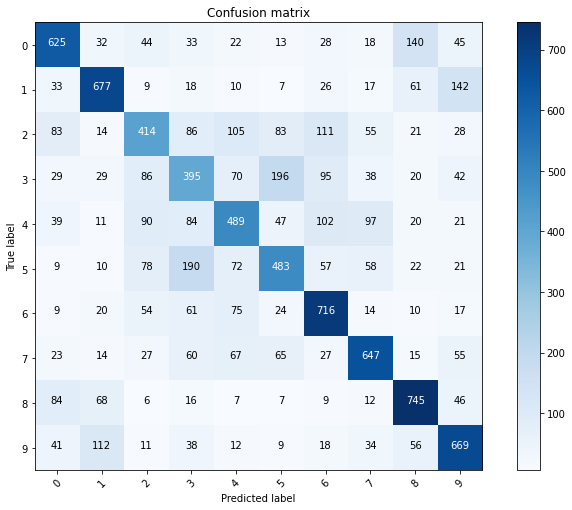

In [35]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
plt.rcParams['figure.figsize'] = [10,7]

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

# clf.predict(feature_test)
p_test = clf.predict(feature_test)
# clf.predict(lags1).argmax(axis=0)
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

Normalized confusion matrix
[[0.625 0.032 0.044 0.033 0.022 0.013 0.028 0.018 0.14  0.045]
 [0.033 0.677 0.009 0.018 0.01  0.007 0.026 0.017 0.061 0.142]
 [0.083 0.014 0.414 0.086 0.105 0.083 0.111 0.055 0.021 0.028]
 [0.029 0.029 0.086 0.395 0.07  0.196 0.095 0.038 0.02  0.042]
 [0.039 0.011 0.09  0.084 0.489 0.047 0.102 0.097 0.02  0.021]
 [0.009 0.01  0.078 0.19  0.072 0.483 0.057 0.058 0.022 0.021]
 [0.009 0.02  0.054 0.061 0.075 0.024 0.716 0.014 0.01  0.017]
 [0.023 0.014 0.027 0.06  0.067 0.065 0.027 0.647 0.015 0.055]
 [0.084 0.068 0.006 0.016 0.007 0.007 0.009 0.012 0.745 0.046]
 [0.041 0.112 0.011 0.038 0.012 0.009 0.018 0.034 0.056 0.669]]


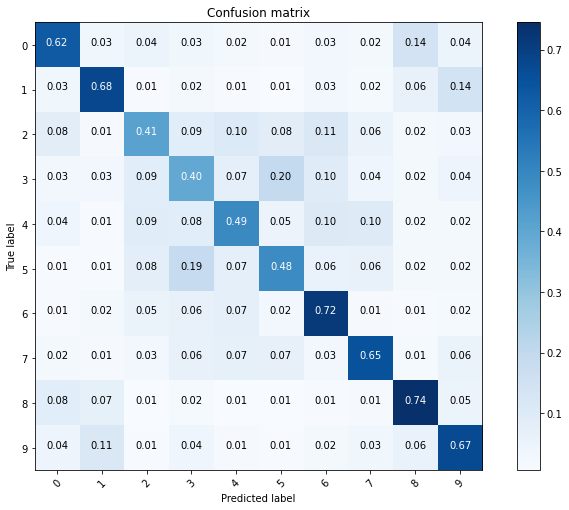

In [36]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
plt.rcParams['figure.figsize'] = [10,7]

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

# clf.predict(feature_test)
p_test = clf.predict(feature_test)
# clf.predict(lags1).argmax(axis=0)
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

In [0]:
airplane : 0
automobile : 1
bird : 2
cat : 3
deer : 4
dog : 5
frog : 6
horse : 7
ship : 8
truck : 9